# Webscraping, Analyzing & sending custom emails on COVID-19

## Author: AKHIL JAMES

## 1. Import libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import datetime
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from email.mime.base import MIMEBase
from email import encoders

## 2. Webscraping

### 2.a. Fetch data from the webpage

In [2]:
URL = 'https://worldometers.info/coronavirus/'

headers = {"User-Agent": 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'}
page=requests.get(URL, headers=headers)
soup=BeautifulSoup(page.content, 'html.parser')

### 2.b. Arrange the data into a list

In [3]:
covid19_data = []   #initiate empty list to store data

web_table = soup.find('table', {'id': 'main_table_countries_today'})  #look for the table in web page

table_rows = web_table.find_all('tr')   #find rows

#iterate through rows and append contents of each row to the list
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    covid19_data.append(row)

covid19_data = covid19_data [1:] #remove blank/duplicate first row

## 3. Data wrangling

### 3.a. Convert the data into a pandas dataframe

In [4]:
#convert data into a pandas data frame and insert headers
df = pd.DataFrame(covid19_data)
df = df.iloc[:, 1:13] #remove first column with index and get data from the rest 12 columns
df.columns = ['Country/Other', 'Total_Cases', 'New_Cases', 'Total_Deaths', 'New_Deaths', 
              'Total_Recovered', 'Active_Cases', 'Serious/Critical', 'Cases_per_1M', 
              'Deaths_per_1M', 'Total_Tests', 'Test_per_1M']


df.replace('', 0, inplace=True)  #replace all empty string with 0 
df.replace(' ', 0, inplace=True) #replace  strings with just space with 0 
df.replace(np.nan, 0, inplace=True) #replace  nan with 0
df.replace('N/A', 0, inplace=True) #replace  'N/A' with 0

#drop data about continents
values_to_drop = ['North America', 'South America', 'Asia', 'Africa', 'Oceania', 'Total', 'Europe', 'World', '\n\n']

for drop_value in range (len(values_to_drop)):
    df = df[~df['Country/Other'].str.contains(str(values_to_drop[drop_value]))]

df

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M,Total_Tests,Test_per_1M
8,USA,"1,683,005","+16,177","99,229",+546,"451,416","1,132,360","17,131","5,088",300,"14,678,825","44,374"
9,Brazil,"357,839","+10,441","22,500",+487,"142,587","192,752","8,318","1,685",106,"735,224","3,461"
10,Russia,"344,481","+8,599","3,541",+153,"113,299","227,641","2,300","2,361",24,"8,685,305","59,518"
11,Spain,"282,852",+482,"28,752",+74,"196,958","57,142",854,"6,050",615,"3,556,567","76,071"
12,UK,"259,559","+2,405","36,793",+118,0,0,"1,559","3,826",542,"3,458,905","50,979"
...,...,...,...,...,...,...,...,...,...,...,...,...
218,Western Sahara,6,0,0,0,6,0,0,10,0,0,0
219,Anguilla,3,0,0,0,3,0,0,200,0,30,"2,001"
220,Lesotho,2,0,0,0,0,2,0,0.9,0,283,132
221,Saint Pierre Miquelon,1,0,0,0,1,0,0,173,0,0,0


In [5]:
# Get data from totals row. #Not used in plotting

tag = soup.find(class_="total_row_body")

total_rows = tag.find_all('td')

total_row = [i.text for i in total_rows]
total_row = total_row[1:13]
print(total_row)

['Total:', '5,481,509', '+83,559', '346,074', '+2,466', '2,290,800', '2,844,635', '53,195', '703.2', '44.4', '', '']


In [6]:
df = df.drop(columns=['Total_Tests', 'Test_per_1M']) #dropping last two column as it is not used later

df.head()

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M
8,USA,"1,683,005","+16,177","99,229",+546,"451,416","1,132,360","17,131","5,088",300
9,Brazil,"357,839","+10,441","22,500",+487,"142,587","192,752","8,318","1,685",106
10,Russia,"344,481","+8,599","3,541",+153,"113,299","227,641","2,300","2,361",24
11,Spain,"282,852",+482,"28,752",+74,"196,958","57,142",854,"6,050",615
12,UK,"259,559","+2,405","36,793",+118,0,0,"1,559","3,826",542


### 3.b. Convert the datatypes of the columns from object to float

In [7]:
columns_to_convert = list(df.columns)[1:] #list of columns whose datatype should be changed

for column in columns_to_convert:
    df[column] = df[column].str.replace(',','').astype(np.float64)
    
#sort countries with most cases
df=df.sort_values(by=['Total_Cases'], ascending = False)
df.head()

,Country/Other,Total_Cases,New_Cases,Total_Deaths,New_Deaths,Total_Recovered,Active_Cases,Serious/Critical,Cases_per_1M,Deaths_per_1M
8,USA,1683005.0,16177.0,99229.0,546.0,451416.0,1132360.0,17131.0,5088.0,300.0
9,Brazil,357839.0,10441.0,22500.0,487.0,142587.0,192752.0,8318.0,1685.0,106.0
10,Russia,344481.0,8599.0,3541.0,153.0,113299.0,227641.0,2300.0,2361.0,24.0
11,Spain,282852.0,482.0,28752.0,74.0,196958.0,57142.0,854.0,6050.0,615.0
12,UK,259559.0,2405.0,36793.0,118.0,NaN,NaN,1559.0,3826.0,542.0


### 3.c. Extract part of the dataframe to make plots

In [8]:
df1 = df[0:9] #take top 9 countries for plotting
df2 = df[9:] #to make a new category called 'others' to be used in plotting

others = df2.sum(axis = 0, skipna = True)

others['Country/Other']='Others'

others['Cases_per_1M']=others['Cases_per_1M']/len(df2) #average the value
others['Deaths_per_1M']=others['Deaths_per_1M']/len(df2) #average the value


df1 = df1.append(others, ignore_index=True) #append all other countries ('others') to df1


df3=df1[['Country/Other','Total_Cases','Active_Cases','Total_Deaths']] #data in pie chart , used for inserting table in plot


## 4. Plot the data

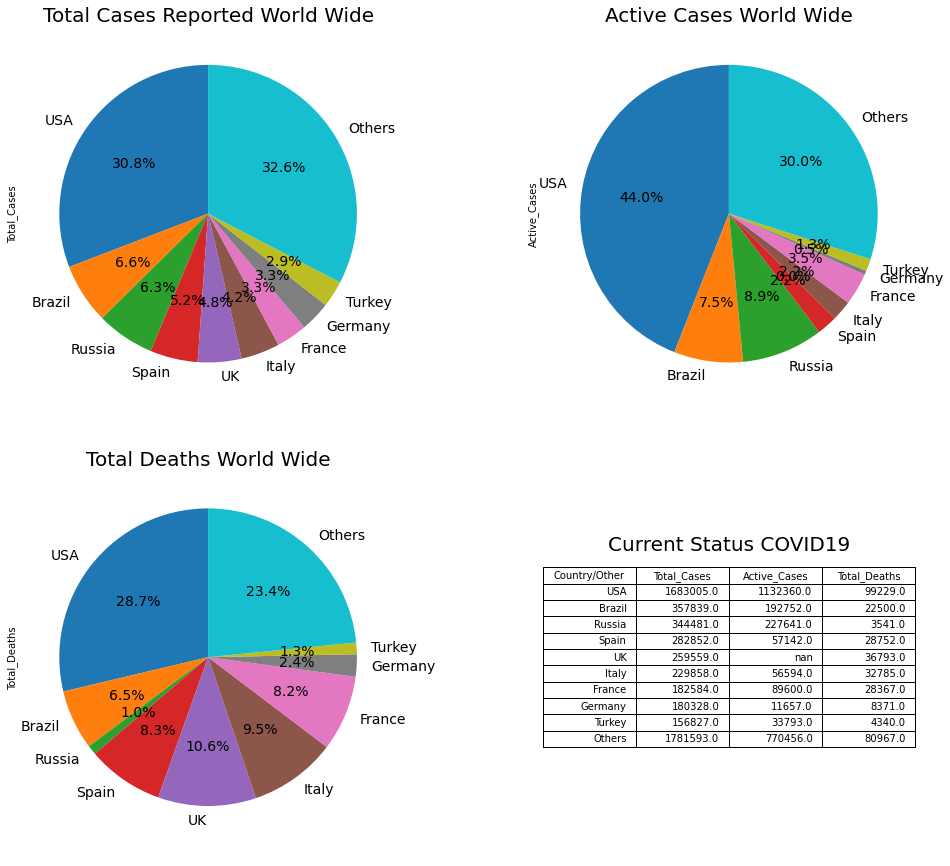

In [9]:
#plot pie charts

plt.figure(figsize=(16,12))

ax1 = plt.subplot(221, aspect='equal')
df1.plot(kind='pie', y = 'Total_Cases', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Total Cases Reported World Wide',fontsize=20)

ax2 = plt.subplot(222, aspect='equal')
df1.plot(kind='pie', y = 'Active_Cases', ax=ax2, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Active Cases World Wide',fontsize=20)

ax3 = plt.subplot(223, aspect='equal')
df1.plot(kind='pie', y = 'Total_Deaths', ax=ax3, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=df1['Country/Other'], legend = False, fontsize=14)
plt.title('Total Deaths World Wide',fontsize=20)

#insert table in the plot
df3_text = []
for df3_row in range(len(df3)):
    df3_text.append(df3.iloc[df3_row])
plt.subplot(224)
plt.table(cellText=df3_text, colLabels=df3.columns, loc='center')
plt.axis('off')
plt.title('Current Status COVID19',fontsize=20, y=0.75)

#adjust allignment of subplots
plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.1, wspace=0.4)
plt.savefig('COVID19_distribution.png', dpi=300)
plt.show()


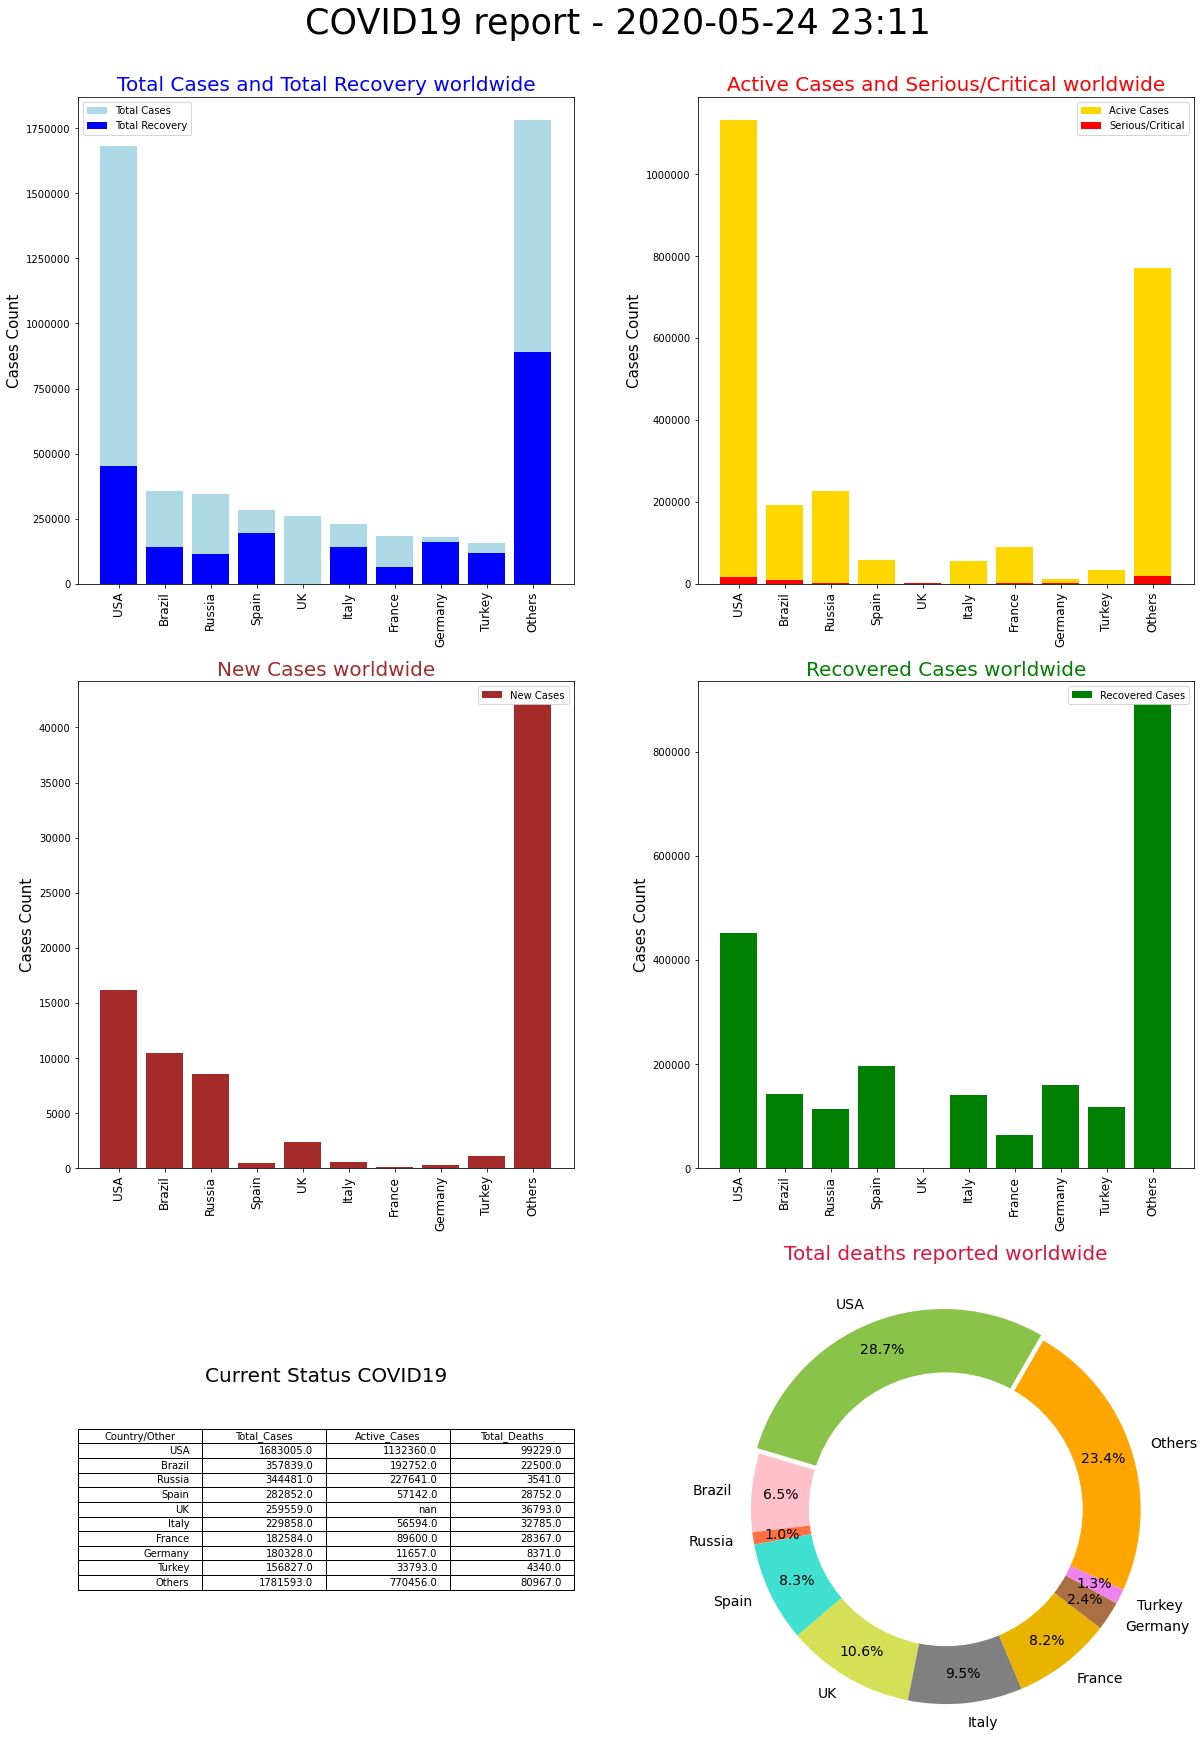

In [10]:
plt.figure(figsize=(20,25))

#plot Total Cases and Total Recovered worldwide in bar plots
ax2 = plt.subplot(321)
country = df1['Country/Other']
tot_cases = df1['Total_Cases']
tot_deaths = df1['Total_Recovered']
ax2.bar(country, tot_cases, color='lightblue')
ax2.bar(country, tot_deaths, color='blue')
ax2.set_ylabel('Cases Count', fontsize=15)
ax2.set_title('Total Cases and Total Recovery worldwide',fontsize=20, color='Blue')
ax2.set_xticklabels(country, rotation=90, fontsize=12)
ax2.legend(["Total Cases", "Total Recovery"])
ax2.ticklabel_format(style='plain', axis='y')


#plot Active Cases and Serious/Critical worldwide in bar plots
ax3 = plt.subplot(322)
country = df1['Country/Other']
act_cases = df1['Active_Cases']
critical = df1['Serious/Critical']
ax3.bar(country, act_cases, color='gold')
ax3.bar(country, critical, color='red')
ax3.set_ylabel('Cases Count', fontsize=15)
ax3.set_title('Active Cases and Serious/Critical worldwide',fontsize=20, color='red')
ax3.set_xticklabels(country, rotation=90, fontsize=12)
ax3.legend(["Acive Cases", "Serious/Critical"])
ax3.ticklabel_format(style='plain', axis='y')


#plot new cases worldwide in bar plots
ax5 = plt.subplot(323)
country = df1['Country/Other']
new_cases = df1['New_Cases']
ax5.bar(country, new_cases, color='brown')
ax5.set_ylabel('Cases Count', fontsize=15)
ax5.set_title('New Cases worldwide',fontsize=20, color='Brown')
ax5.set_xticklabels(country, rotation=90, fontsize=12)
ax5.legend(["New Cases"])
ax5.ticklabel_format(style='plain', axis='y')


#plot Total recovered worldwide in bar plots
ax4 = plt.subplot(324)
country = df1['Country/Other']
rec_cases = df1['Total_Recovered']
ax4.bar(country, rec_cases, color='green')
ax4.set_ylabel('Cases Count', fontsize=15)
ax4.set_title('Recovered Cases worldwide',fontsize=20, color='Green')
ax4.set_xticklabels(country, rotation=90, fontsize=12)
ax4.legend(["Recovered Cases"])
ax4.ticklabel_format(style='plain', axis='y')


#Insert a table into the plot
df3_text = []
for df3_row in range(len(df3)):
    df3_text.append(df3.iloc[df3_row])
plt.subplot(325)
plt.table(cellText=df3_text, colLabels=df3.columns, loc='center')
plt.axis('off')
plt.title('Current Status COVID19',fontsize=20, y=0.75)


#Plot Total deaths world wide as a donut plot
ax1 = plt.subplot(326)
values = df1['Total_Deaths']
labels = df1['Country/Other'].unique()
total = np.sum(values)
colors = ['#8BC34A','Pink','#FE7043','Turquoise','#D4E157','Grey','#EAB300','#AA7043','Violet','Orange']
ax1.pie (values , labels= labels , colors= colors , 
         startangle=60 , autopct='%1.1f%%', pctdistance=0.85, 
         explode=[0.03,0,0,0,0,0,0,0,0,0], textprops={'fontsize': 14} )
my_circle=plt.Circle( (0,0), 0.7, color='white') # Adding circle at the centre
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Total deaths reported worldwide',fontsize=20, color='crimson')

right_now = str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))

#adjust allignment of plots and save
plt.subplots_adjust(top = 0.93, bottom=0.01, hspace=0.2, wspace=0.25)
plt.suptitle('COVID19 report - '+right_now, fontsize=35) #main title of plot
plt.savefig('COVID19_update.png', dpi=500)
plt.show()


## 5. Send the plots as email attachments

In [ ]:
#get current time to indicate in email

right_now = str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M"))

# Open file with email details like user, password and recipient
file = open('email.txt',mode='r')
 
# read lines
all_lines = file.readlines()

# close the file
file.close()

email_user = all_lines[0]       #user name
email_password = all_lines[1]   #password
email_send = all_lines[2]       #recipients

subject = 'COVID19 Current Status'

msg = MIMEMultipart()
msg['From'] = email_user
msg['To'] = email_send
msg['Subject'] = subject

body = 'Hi, \n\nSending the status of COVID19 on '+str(right_now)
msg.attach(MIMEText(body,'plain'))

filenames = ['COVID19_update.png', 'COVID19_distribution.png'] #files to be attached

#attaching files
for file in filenames:
    part = MIMEBase('application', 'octet-stream')
    part.set_payload(open(file, 'rb').read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition', 'attachment; filename="%s"' % file)
    msg.attach(part)

#send email
text = msg.as_string()
server = smtplib.SMTP('smtp.gmail.com')
server.starttls()
server.login(email_user,email_password)

server.sendmail(email_user,email_send,text)
server.quit()